In [1]:
"""
Grid preparation for future aspen project:

Author: maxwell.cook@colorado.edu
"""

import os, sys, time, re
import pandas as pd
import xarray as xr
import geopandas as gpd
import numpy as np
import rasterio as rio
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from matplotlib.ticker import FuncFormatter
from tqdm.notebook import tqdm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import distance_transform_edt

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/')

# Custom functions
sys.path.append(os.path.join(maindir,'aspen-fire/Aim2/code/Python'))
from __functions import *

proj = 'EPSG:5070' # albers

print("Ready to go !")

Ready to go !


## Future Fire

From Stephens et al., In review, annual probability of area burned and fire occurrence. Trend to 2060 was calculated using a median-based linear model (MBLM) thielsen estimate. 

In [2]:
fp = os.path.join(projdir,'Aim3/data/spatial/mod/future_fire_grid_trend.gpkg')
future_fire = gpd.read_file(fp)
future_fire.head()

,grid_id,trend_area,trend_count,p_area,p_count,NA_L3NAME,US_L4NAME,US_L4CODE,geometry
0,159230.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-861518.632 2246765.246, -858285.087..."
1,159231.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-858285.087 2246403.307, -855051.389..."
2,159232.0,190.629216,0.019221,3.590523e-11,1.436235e-13,Southern Rockies,Foothill Shrublands,21d,"POLYGON ((-855051.389 2246042.730, -851817.539..."
3,159233.0,301.282740,0.026862,1.926234e-07,1.677490e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-851817.539 2245683.513, -848583.540..."
4,159234.0,411.936265,0.034504,3.852110e-07,3.354837e-09,Southern Rockies,Crystalline Mid-Elevation Forests,21c,"POLYGON ((-848583.540 2245325.656, -845349.389..."


In [3]:
# check for duplicates, remove them
n = future_fire.duplicated(subset=['grid_id']).sum()
if n > 0:
    print(f"\nThere are [{n}] duplicate rows.\n")
else:
    print("\nNo duplicates at this stage.\n")


No duplicates at this stage.



## Aspen habitat suitability 

From Hart et al. In Review- Calculate the change between past and future (2041-2070) aspen suitability to get the difference (future change in habitat suitability).

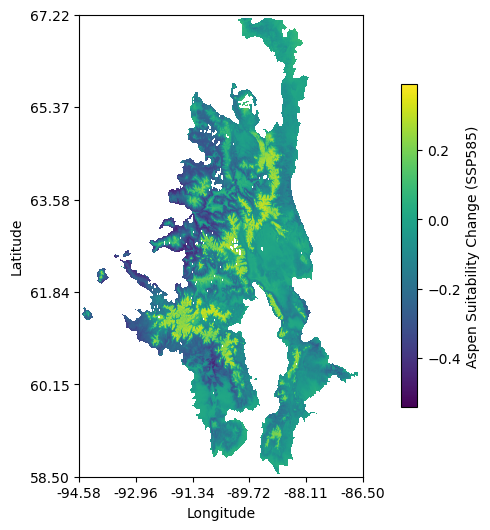

In [4]:
# load the future aspen suitability predictions
dir = os.path.join(projdir,'Aim3/data/spatial/raw/aspen_suitability/Predictions/')
# historical suitability
hist = os.path.join(dir,'predicted_historical_1981-2010_ensemble.tif')
# future suitability (SSP245 2041-2070)
ssp245 = os.path.join(dir,'predicted_SSP245_2041-2070_ensemble.tif')
# future suitability (SSP585 2041-2070)
ssp585 = os.path.join(dir,'predicted_SSP585_2041-2070_ensemble.tif')

# load each raster
hist_da = rxr.open_rasterio(hist, masked=True, cache=False).squeeze()
ssp245_da = rxr.open_rasterio(ssp245, masked=True, cache=False).squeeze()
ssp585_da = rxr.open_rasterio(ssp585, masked=True, cache=False).squeeze()

# calculate the change in suitability under both scenarios
change_SSP245 = ssp245_da - hist_da
change_SSP585 = ssp585_da - hist_da

# check the results
out_png = os.path.join(projdir, 'Aim3/figures/srm_aspen_suitability_change_ssp585.png')
plot_raster(change_SSP585, legend_lab = "Aspen Suitability Change (SSP585)", save_file=True, out_png=out_png)

In [5]:
change_SSP245.rio.crs

CRS.from_epsg(32613)

In [6]:
# calculate band statistics
# mean, standard deviation, percentiles

# create a list of rasters to calculate zonal stats
das = {
    'historic': hist_da, # historic (1981-2010) suitability
    'ssp245': ssp245_da, # raw suitability SSP245 2041-2070
    'ssp585': ssp585_da, # raw suitability SSP585 2041-2070
    'delta245': change_SSP245, # change SSP245 2041-2070
    'delta585': change_SSP585 # change SSP585 2041-2070
}

results = []
for key, da in das.items():
    print(f"Processing: {key}")
    # ensure the correct projection
    da_ = da.rio.reproject(proj) # matches grid
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=future_fire, 
        image_da=da_, 
        id_col='grid_id', 
        stats=['mean'], # 'median','std','percentile_90'
        attr=key,
        ztype='continuous'
    )
    results.append(zs)

# concatenate the results
future_aspen = pd.concat([df.set_index("grid_id") for df in results], axis=1).reset_index()
future_aspen.head()

Processing: historic
Processing: ssp245
Processing: ssp585
Processing: delta245
Processing: delta585


,grid_id,historic_mean,ssp245_mean,ssp585_mean,delta245_mean,delta585_mean
0,159230.0,0.077949,0.141750,0.188673,0.063800,0.110724
1,159231.0,0.079767,0.128937,0.173096,0.049170,0.093329
2,159232.0,0.095146,0.151842,0.198710,0.056696,0.103564
3,159233.0,0.138749,0.158245,0.199029,0.019496,0.060280
4,159234.0,0.212962,0.201934,0.235828,-0.011028,0.022866


In [7]:
# rename the columns
future_aspen = future_aspen.rename(
    columns={
        'historic_mean': 'historic',
        'ssp245_mean': 'ssp245',
        'ssp585_mean': 'ssp585',
        'delta245_mean': 'delta245',
        'delta585_mean': 'delta585'
    }
)

# join to the fire dataframe
fire_fa = pd.merge(future_fire, future_aspen, on="grid_id", how="left")
fire_fa.head()

# save this file out
out_fp = os.path.join(projdir, 'Aim3/data/spatial/mod/future_fire_grid_trend_aspen.gpkg')
fire_fa.to_file(out_fp)
print(f"Saved to: \n{out_fp}")

Saved to: 
/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim3/data/spatial/mod/future_fire_grid_trend_aspen.gpkg


In [8]:
# tidy up
del das, results, zs, hist_da, ssp245_da, ssp585_da, change_SSP245, change_SSP585, future_aspen
gc.collect()

133

## Sentinel-based aspen cover (ca. 2019)

From Cook et al. (2024), calculate the percent aspen canopy cover within gridcells. This should ideally be updated to 2023 ...

In [9]:
t0 = time.time()

# load the 10-m aspen map (classification)
aspen10_fp = os.path.join(projdir,'Aim1/data/spatial/mod/results/classification/s2aspen_distribution_10m_y2019_CookEtAl.tif')
aspen10 = rxr.open_rasterio(aspen10_fp, cache=False, chunks='auto', mask=True).squeeze()
print(f"\n{aspen10}\n")
print(aspen10.rio.crs)

# calculate zonal statistics
aspen10_grids = compute_band_stats(
    geoms=future_fire, 
    image_da=aspen10, 
    id_col='grid_id', 
    attr='aspen10',
    ztype='categorical'
)

# only keep the count of aspen pixels
aspen10_grids = aspen10_grids[aspen10_grids['aspen10'] == 1]
# check the results
print(aspen10_grids.head())

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.\n")
print("\n~~~~~~~~~~\n")


<xarray.DataArray (y: 95433, x: 64151)> Size: 6GB
dask.array<getitem, shape=(95433, 64151), dtype=uint8, chunksize=(2092, 64151), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 513kB -1.217e+06 -1.217e+06 ... -5.76e+05 -5.76e+05
  * y            (y) float64 763kB 2.309e+06 2.309e+06 ... 1.355e+06 1.355e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        1
    STATISTICS_MEAN:           0.015830995519141
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         0.1248213727693
    STATISTICS_VALID_PERCENT:  100
    _FillValue:                255
    scale_factor:              1.0
    add_offset:                0.0

EPSG:5070
    grid_id  aspen10  count  total_pixels  pct_cover
1  159230.0        1      8        146335   0.005467
3  159231.0        1     23        146342   0.015717
5  159232.0        1    764        146346   0.522050
7  1592

In [10]:
aspen10_grids['pct_cover'].describe()

count    9212.000000
mean        6.760243
std        11.574808
min         0.000617
25%         0.204016
50%         1.432681
75%         7.450748
max        80.162397
Name: pct_cover, dtype: float64

In [11]:
# rename for clarity
aspen10_grids.rename(columns={
    'pct_cover': 'aspen10_pct',
    'count': 'aspen10_pixn'
}, inplace=True)

# merge back to the main grid data
fire_fa_ = pd.merge(fire_fa, aspen10_grids[['grid_id','aspen10_pct','aspen10_pixn']], on='grid_id')
fire_fa_.columns

Index(['grid_id', 'trend_area', 'trend_count', 'p_area', 'p_count',
       'NA_L3NAME', 'US_L4NAME', 'US_L4CODE', 'geometry', 'historic', 'ssp245',
       'ssp585', 'delta245', 'delta585', 'aspen10_pct', 'aspen10_pixn'],
      dtype='object')

In [12]:
del aspen10, aspen10_grids, fire_fa
gc.collect() # free memory

441

## Built Environment Summaries

COMBUST, Microsoft Building Footprints, WorldPop population density/counts, and WUI classification (10-m)

In [13]:
# Contemporary COMBUST grid (combustible mass of the built environment)
combust_fp = os.path.join(projdir,'Aim3/data/spatial/raw/COMBUST/combustible_building_mass_t_2020_mean.tif')
# Miscrosoft building footprint counts (same grid as COMBUST)
msbf_fp = os.path.join(maindir,'earth-lab/opp-urban-fuels/data/spatial/mod/Microsoft/msbf_counts.tif')
# WorldPop population density estimates
wp_density_fp = os.path.join(projdir,'Aim3/data/spatial/raw/WorldPop/usa_pd_2020_1km.tif')
wp_count_fp = os.path.join(projdir,'Aim3/data/spatial/raw/WorldPop/srm_ppp_2020_constrained.tif')

# put the continuous rasters in a dictionary to calculate zonal stats
das = {
    'combust': combust_fp,
    'msbf_count': msbf_fp,
    'pop_density': wp_density_fp,
    'pop_count': wp_count_fp,
}

results = []
# map the dictionary, calculate zonal stats
for key, fp in das.items():
    print(f"Processing: {key}")
    # process the raster grid
    da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
    da = da.rio.reproject(proj) # ensure matching projection
    if key == 'pop_density':
        stat = ['mean']
    else:
        stat = ['sum']
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=future_fire, 
        image_da=da, 
        id_col='grid_id', 
        stats=stat, 
        attr=key,
        ztype='continuous'
    )
    results.append(zs)
    del da, zs
    
# concatenate the results
built_env_pop = pd.concat([df.set_index("grid_id") for df in results], axis=1).reset_index()
built_env_pop.head()

Processing: combust
Processing: msbf_count
Processing: pop_density
Processing: pop_count


,grid_id,combust_sum,msbf_count_sum,pop_density_mean,pop_count_sum
0,159230.0,866.741028,40.0,1.012462,NaN
1,159231.0,2105.277588,84.0,5.431233,21.508411
2,159232.0,6195.236816,247.0,16.635210,193.112381
3,159233.0,1774.940186,96.0,4.073417,NaN
4,159234.0,3126.656250,141.0,8.421898,NaN


### Wildland Urban Interface/Intermix (SILVIS)

In [14]:
# load the results from "wui-summary.ipynb"
fp = os.path.join(projdir, 'Aim3/data/tabular/srm_wui_grid_stats.csv')
wui = pd.read_csv(fp)
wui.drop(columns=['Unnamed: 0'], inplace=True)
wui.head()

,grid_id,wui1,wui2,wui3,wui4,wui_dist_mean
0,159230.0,0.0,0.0,6.532839,0.029470,1038.492751
1,159231.0,0.0,0.0,15.458371,0.006854,636.598957
2,159232.0,0.0,0.0,35.265412,0.000000,308.430041
3,159233.0,0.0,0.0,11.896978,0.000000,721.659559
4,159234.0,0.0,0.0,12.335940,0.000000,1341.741558


In [15]:
# merge the built environment stats with the wui stats
wui_bltenv = pd.merge(built_env_pop, wui, on='grid_id', how='left')
wui_bltenv.columns

Index(['grid_id', 'combust_sum', 'msbf_count_sum', 'pop_density_mean',
       'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4', 'wui_dist_mean'],
      dtype='object')

In [16]:
# merge to the future fire grid
fire_fa_bltenv = pd.merge(fire_fa_, wui_bltenv, on='grid_id', how='left')
fire_fa_bltenv.columns

Index(['grid_id', 'trend_area', 'trend_count', 'p_area', 'p_count',
       'NA_L3NAME', 'US_L4NAME', 'US_L4CODE', 'geometry', 'historic', 'ssp245',
       'ssp585', 'delta245', 'delta585', 'aspen10_pct', 'aspen10_pixn',
       'combust_sum', 'msbf_count_sum', 'pop_density_mean', 'pop_count_sum',
       'wui1', 'wui2', 'wui3', 'wui4', 'wui_dist_mean'],
      dtype='object')

## Contemporary Fire Activity and Fire Risk 

### Ignition Causes

In [17]:
# load the fpa-fod ignitions data and get the total count
fpa_fp = os.path.join(projdir,'Aim3/data/spatial/mod/fire/srm_fpa_fod.gpkg')
fpa = gpd.read_file(fpa_fp)
fpa.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'geometry'],
      dtype='object')

In [18]:
print(fpa['FIRE_YEAR'].min())
print(fpa['FIRE_YEAR'].max())

1992
2020


In [19]:
# load the ICS (for 2021-2023)


In [20]:
fpa['NWCG_CAUSE_CLASSIFICATION'].unique()

array(['Natural', 'Human', 'Missing data/not specified/undetermined'],
      dtype=object)

In [21]:
# calculate the area burned by ignition cause
cause_burned = (
    fpa.groupby('NWCG_CAUSE_CLASSIFICATION', as_index=False)
    .agg(
        area_burned=('FIRE_SIZE','sum'),
        fire_count=('OBJECTID', 'count')   
    )
)
# rename the cause column
cause_burned.rename(columns={'NWCG_CAUSE_CLASSIFICATION': 'cause'}, inplace=True)
# replace the undetermined code
cause_burned['cause'] = cause_burned['cause'].replace(
    "Missing data/not specified/undetermined", "Undetermined"
)
# check the results
cause_burned.head()

,cause,area_burned,fire_count
0,Human,1605750.430,12215
1,Undetermined,276192.421,2659
2,Natural,1161911.098,16039


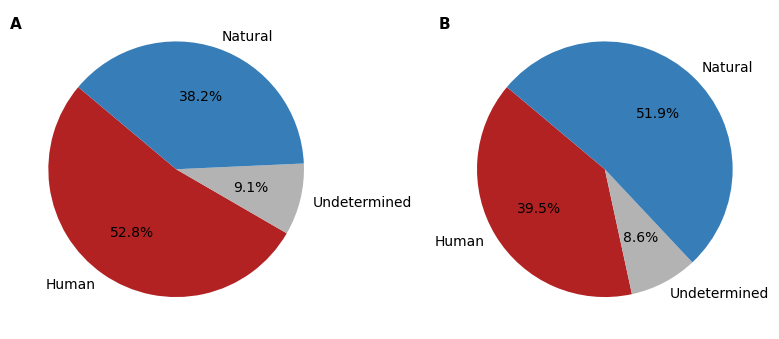

In [22]:
# Define labels and values for both metrics
labels = cause_burned['cause']
sizes_area = cause_burned['area_burned']
sizes_count = cause_burned['fire_count']

# define color mapping
color_map = {
    "Human": "#B22222",        
    "Natural": "#377EB8",      
    "Undetermined": "#B3B3B3"  
}
# map the colors
colors = [color_map.get(cause, "#CCCCCC") for cause in cause_burned["cause"]]

# Create subplots for two pie charts
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].pie(sizes_area, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[0].text(-1.3, 1.1, "A", fontsize=11, fontweight="bold")  # Add subplot label "A"
axes[1].pie(sizes_count, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axes[1].text(-1.3, 1.1, "B", fontsize=11, fontweight="bold")  # Add subplot label "B"

# Show plot
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'Aim3/figures/FPA-FOD_cause_pie.png'), dpi=300, bbox_inches='tight')

plt.show()

In [23]:
del fpa

### Burned Area

In [24]:
# load burned area and calculate the cumulative area burned
mtbs_fp = os.path.join(projdir,'Aim3/data/spatial/mod/fire/srm_mtbs_perims_dd.gpkg')
mtbs = gpd.read_file(mtbs_fp)
mtbs.columns

Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry'],
      dtype='object')

In [25]:
mtbs['Ig_Date'] = pd.to_datetime(mtbs['Ig_Date'])
mtbs['Fire_Year'] = mtbs['Ig_Date'].dt.year
mtbs[['Ig_Date','Fire_Year']].head()

,Ig_Date,Fire_Year
0,1987-07-07,1987
1,1987-07-02,1987
2,1989-09-25,1989
3,1989-07-09,1989
4,1989-07-08,1989


In [26]:
print(mtbs['Fire_Year'].min())
print(mtbs['Fire_Year'].max())

1984
2023


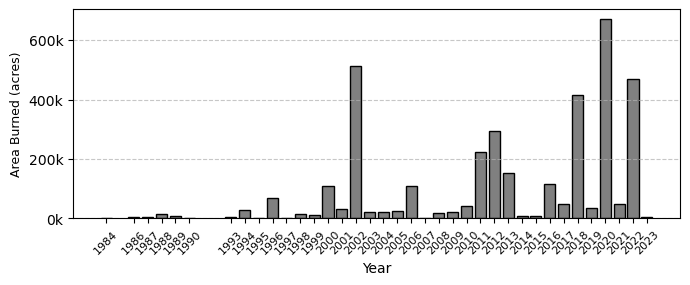

In [27]:
# plot the annual area burned
burned_area = mtbs.groupby('Fire_Year')['BurnBndAc'].sum().reset_index()

# Function to format colorbar labels with 'k' notation
def format_ticks(value, _):
    return f'{int(value / 1000)}k'

formatter = FuncFormatter(format_ticks)

# Plot the results
plt.figure(figsize=(7, 3))
plt.bar(burned_area['Fire_Year'], burned_area['BurnBndAc'], color='grey', edgecolor='black')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Area Burned (acres)', fontsize=9)
plt.xticks(burned_area['Fire_Year'], rotation=45, size=8)

# Apply custom formatting to y-axis
plt.gca().yaxis.set_major_formatter(formatter)
# plt.ylim(10000, None)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(os.path.join(projdir, 'Aim3/figures/MTBS_annualBurnedArea.png'), dpi=300, bbox_inches='tight')

plt.show()

In [28]:
# calculate the cumulative previous area burned
mtbs = mtbs.to_crs(proj) # ensure the correct CRS
mtbs_in_grid = gpd.overlay(mtbs, future_fire, how='intersection') # perform the overlay

# get the cumulative burned area in each grid cell
mtbs_in_grid['burned_area_c'] = mtbs_in_grid.geometry.area
burned_area_c = mtbs_in_grid.groupby('grid_id', as_index=False)['burned_area_c'].sum()
# calculate the cumulative percent burned
# get the gridcell area
df = future_fire.copy()
df['grid_area'] = df.geometry.area

# merge burned area summary back to grid cells
burned_area_c = df[['grid_id','grid_area','geometry']].merge(burned_area_c, on='grid_id', how='left')
# fill NaN values (for grid cells with no fire) with 0
burned_area_c['burned_area_c'] = burned_area_c['burned_area_c'].fillna(0)
# Compute percentage of each grid cell burned
burned_area_c['burned_pct_c'] = (burned_area_c['burned_area_c'] / burned_area_c['grid_area']) * 100

# merge back to the main grid data
fire_fa_bltenv_ba = pd.merge(fire_fa_bltenv, burned_area_c, on='grid_id', how='left')
fire_fa_bltenv_ba.columns

Index(['grid_id', 'trend_area', 'trend_count', 'p_area', 'p_count',
       'NA_L3NAME', 'US_L4NAME', 'US_L4CODE', 'geometry_x', 'historic',
       'ssp245', 'ssp585', 'delta245', 'delta585', 'aspen10_pct',
       'aspen10_pixn', 'combust_sum', 'msbf_count_sum', 'pop_density_mean',
       'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4', 'wui_dist_mean',
       'grid_area', 'geometry_y', 'burned_area_c', 'burned_pct_c'],
      dtype='object')

In [29]:
del mtbs, mtbs_in_grid, burned_area_c, fire_fa_bltenv, df
gc.collect()

48

### Wildfire Hazard Potential (version 2023)

In [30]:
# load the wildfire hazard potential
fp = os.path.join(projdir,'Aim3/data/spatial/raw/fsim/Data/whp2023_GeoTIF/whp2023_cnt_conus.tif')
whp = rxr.open_rasterio(fp, masked=True, chunks='auto').squeeze()
whp = whp.rio.reproject(proj) # matches grid
# calculate the zonal stats
whp_zs = compute_band_stats(
    geoms=future_fire, 
    image_da=whp, 
    id_col='grid_id', 
    stats=['percentile_90'], # 'median','std','percentile_90'
    attr='whp',
    ztype='continuous'
)
whp_zs.head()

,grid_id,whp_percentile_90
0,159230.0,129.1
1,159231.0,245.0
2,159232.0,263.8
3,159233.0,395.6
4,159234.0,424.2


In [31]:
# merge back to the main grid data
whp_zs.rename(columns={'whp_percentile_90': 'whp_p90'}, inplace = True) # tidy columns name first
fire_fa_bltenv_ba_hz = pd.merge(fire_fa_bltenv_ba, whp_zs, on='grid_id', how='left')
fire_fa_bltenv_ba_hz.columns

Index(['grid_id', 'trend_area', 'trend_count', 'p_area', 'p_count',
       'NA_L3NAME', 'US_L4NAME', 'US_L4CODE', 'geometry_x', 'historic',
       'ssp245', 'ssp585', 'delta245', 'delta585', 'aspen10_pct',
       'aspen10_pixn', 'combust_sum', 'msbf_count_sum', 'pop_density_mean',
       'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4', 'wui_dist_mean',
       'grid_area', 'geometry_y', 'burned_area_c', 'burned_pct_c', 'whp_p90'],
      dtype='object')

In [32]:
del fire_fa_bltenv_ba, whp_zs, whp
gc.collect()

31

## LANDFIRE Existing Vegetation (ca. 2023)

In [38]:
# list out the landfire GeoTIFFs
# veg Type, Height, and Cover
lf_dir = os.path.join(projdir,'Aim3/data/spatial/mod/landfire/')
lf_tiffs = list_files(lf_dir, '*.tif', recursive=True)
lf_tiffs = [f for f in lf_tiffs if any(sub in f for sub in ['cc', 'ch', 'evt'])]
print([os.path.basename(f) for f in lf_tiffs])

['srm_lf23_evt_240.tif', 'srm_lc23_cc_240.tif', 'srm_lc23_ch_240.tif']


In [53]:
# calculate the percent cover from EVT classes
evt = rxr.open_rasterio(lf_tiffs[0], masked=True).squeeze()
print(evt.rio.crs)

# calculate the percent cover of WUI classes for each grid
t0 = time.time()

# see __functions.py
evt_grid = compute_band_stats(future_fire, evt, 'grid_id', attr='evt')
# tidy columns in the summary table
evt_grid['count'] = evt_grid['count'].astype(int)
evt_grid['total_pixels'] = evt_grid['total_pixels'].astype(int)
evt_grid.rename(columns = {'count': 'evt_pixels'}, inplace=True)
print(evt_grid.head())


t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del evt # clean up 
gc.collect()

EPSG:5070
    grid_id   evt  evt_pixels  total_pixels  pct_cover
0  159230.0  7011           7         16450   0.042553
1  159230.0  7049          23         16450   0.139818
2  159230.0  7054           5         16450   0.030395
3  159230.0  7066          60         16450   0.364742
4  159230.0  7072           3         16450   0.018237

Total elapsed time: 0.28 minutes.

~~~~~~~~~~



56

In [54]:
# load the lookup table
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2023/LF2023_EVT_240_CONUS/CSV_Data/LF23_EVT_240.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)
# join to the grid
evt_grid = pd.merge(evt_grid, lookup, left_on='evt', right_on='VALUE', how='left')
print(evt_grid[['grid_id','evt','pct_cover','EVT_NAME','SAF_SRM']].head())
# save this file out
out_fp = os.path.join(projdir, 'Aim3/data/tabular/srm_evt_grid_summary.csv')
evt_grid.to_csv(out_fp)
print(f"Saved to: \n{out_fp}")

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')
    grid_id   evt  pct_cover  \
0  159230.0  7011   0.042553   
1  159230.0  7049   0.139818   
2  159230.0  7054   0.030395   
3  159230.0  7066   0.364742   
4  159230.0  7072   0.018237   

                                            EVT_NAME  \
0           Rocky Mountain Aspen Forest and Woodland   
1  Rocky Mountain Foothill Limber Pine-Juniper Wo...   
2    Southern Rocky Mountain Ponderosa Pine Woodland   
3       Inter-Mountain Basins Mat Saltbush Shrubland   
4  Wyoming Basins Dwarf Sagebrush Shrubland and S...   

                            SAF_SRM  
0                    SAF 217: Aspen  
1              SAF 219: Limber Pine  
2  SAF 237: Interior Ponderosa Pine  
3      SRM 501: Saltbush-Greasewood  
4          SRM 405: Black Sagebrush  
Saved to:

In [55]:
# gather the top three most dominant vegetation types
# tidy the SAF column
evt_grid["SAF_SRM"] = evt_grid["SAF_SRM"].str.split(":", n=1).str[1].str.strip()

# Function to get the top X by percent cover
def dom_spps(df):
    top_three = df.nlargest(4, 'pct_cover')  # Get top three by percent cover
    return pd.Series({
        'dom_evt1': top_three.iloc[0]['SAF_SRM'] if len(top_three) > 0 else None,
        'dom_evt2': top_three.iloc[1]['SAF_SRM'] if len(top_three) > 1 else None,
        'dom_evt3': top_three.iloc[2]['SAF_SRM'] if len(top_three) > 2 else None,
        'dom_evt4': top_three.iloc[3]['SAF_SRM'] if len(top_three) > 3 else None
    })

# Apply function per grid_id
dom_evts = evt_grid.groupby('grid_id').apply(dom_spps).reset_index()
dom_evts.head(10)

,grid_id,dom_evt1,dom_evt2,dom_evt3,dom_evt4
0,159230.0,Agriculture,Big Sagebrush-Bluebunch Wheatgrass,Mountain Big Sagebrush,Agriculture
1,159231.0,Agriculture,Big Sagebrush-Bluebunch Wheatgrass,Agriculture,Wyoming Big Sagebrush
2,159232.0,Big Sagebrush-Bluebunch Wheatgrass,Agriculture,Mountain Big Sagebrush,Developed
3,159233.0,Big Sagebrush-Bluebunch Wheatgrass,Mountain Big Sagebrush,Wyoming Big Sagebrush,Chokecherry-Serviceberry-Rose
4,159234.0,Mountain Big Sagebrush,Chokecherry-Serviceberry-Rose,Interior Ponderosa Pine,Big Sagebrush-Bluebunch Wheatgrass
5,159235.0,Mountain Big Sagebrush,Wheatgrass-Bluestem-Needlegrass,Interior Ponderosa Pine,Chokecherry-Serviceberry-Rose
6,159236.0,Interior Ponderosa Pine,Wheatgrass-Bluestem-Needlegrass,Interior Douglas-Fir,Mountain Big Sagebrush
7,159237.0,Interior Ponderosa Pine,Wheatgrass-Bluestem-Needlegrass,Interior Douglas-Fir,Lodgepole Pine
8,159238.0,Wheatgrass-Bluestem-Needlegrass,Interior Ponderosa Pine,Interior Douglas-Fir,Lodgepole Pine
9,159239.0,Mountain Big Sagebrush,Wheatgrass-Bluestem-Needlegrass,Interior Ponderosa Pine,Chokecherry-Serviceberry-Rose


In [57]:
# calculate the continuous summaries (forest canopy percent and height)
ccs = {
    'forest_cc': lf_tiffs[1],
    'forest_ch': lf_tiffs[2]
}
results = [] # store results
for key, fp in ccs.items():
    print(f"Processing: {os.path.basename(fp)}")
    da = rxr.open_rasterio(fp, masked=True, chunks='auto').squeeze()
    # calculate zonal statistics
    zs = compute_band_stats(
        geoms=future_fire, 
        image_da=da, 
        id_col='grid_id', 
        stats=['mean'], 
        attr=key,
        ztype='continuous'
    )
    results.append(zs)
    del da, zs

# concatenate the results
fc_summary = pd.concat([df.set_index("grid_id") for df in results], axis=1).reset_index()
fc_summary.head()

Processing: srm_lc23_cc_240.tif
Processing: srm_lc23_ch_240.tif


,grid_id,forest_cc_mean,forest_ch_mean
0,159230.0,0.080547,0.210942
1,159231.0,1.825889,4.680036
2,159232.0,2.939889,8.916307
3,159233.0,3.734123,10.322091
4,159234.0,4.345553,13.254301


In [58]:
# join the LANDFIRE summaries
lf_summary = pd.merge(dom_evts, fc_summary, on='grid_id', how='left')
lf_summary.columns

Index(['grid_id', 'dom_evt1', 'dom_evt2', 'dom_evt3', 'dom_evt4',
       'forest_cc_mean', 'forest_ch_mean'],
      dtype='object')

In [60]:
# join to the main grid, export
fire_fa_bltenv_ba_hz_lf = pd.merge(fire_fa_bltenv_ba_hz, lf_summary, on='grid_id', how='left')
print(fire_fa_bltenv_ba_hz_lf.columns)
# export
out_fp = os.path.join(projdir, 'Aim3/data/spatial/mod/srm_model_data.gpkg')
fire_fa_bltenv_ba_hz_lf.to_csv(out_fp)
print(f"Saved to: \n{out_fp}")

Index(['grid_id', 'trend_area', 'trend_count', 'p_area', 'p_count',
       'NA_L3NAME', 'US_L4NAME', 'US_L4CODE', 'geometry_x', 'historic',
       'ssp245', 'ssp585', 'delta245', 'delta585', 'aspen10_pct',
       'aspen10_pixn', 'combust_sum', 'msbf_count_sum', 'pop_density_mean',
       'pop_count_sum', 'wui1', 'wui2', 'wui3', 'wui4', 'wui_dist_mean',
       'grid_area', 'geometry_y', 'burned_area_c', 'burned_pct_c', 'whp_p90',
       'dom_evt1', 'dom_evt2', 'dom_evt3', 'dom_evt4', 'forest_cc_mean',
       'forest_ch_mean'],
      dtype='object')
Saved to: 
/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim3/data/spatial/mod/srm_model_data.gpkg
